In [47]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tarfile
import urllib.request
import pprint
import joblib

from pandas import DataFrame
from pandas.plotting import scatter_matrix

from scipy.stats import randint
from scipy import stats

from zlib import crc32

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Getting the data

Getting the data and splitting it into train/test sets

In [2]:
def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  
  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


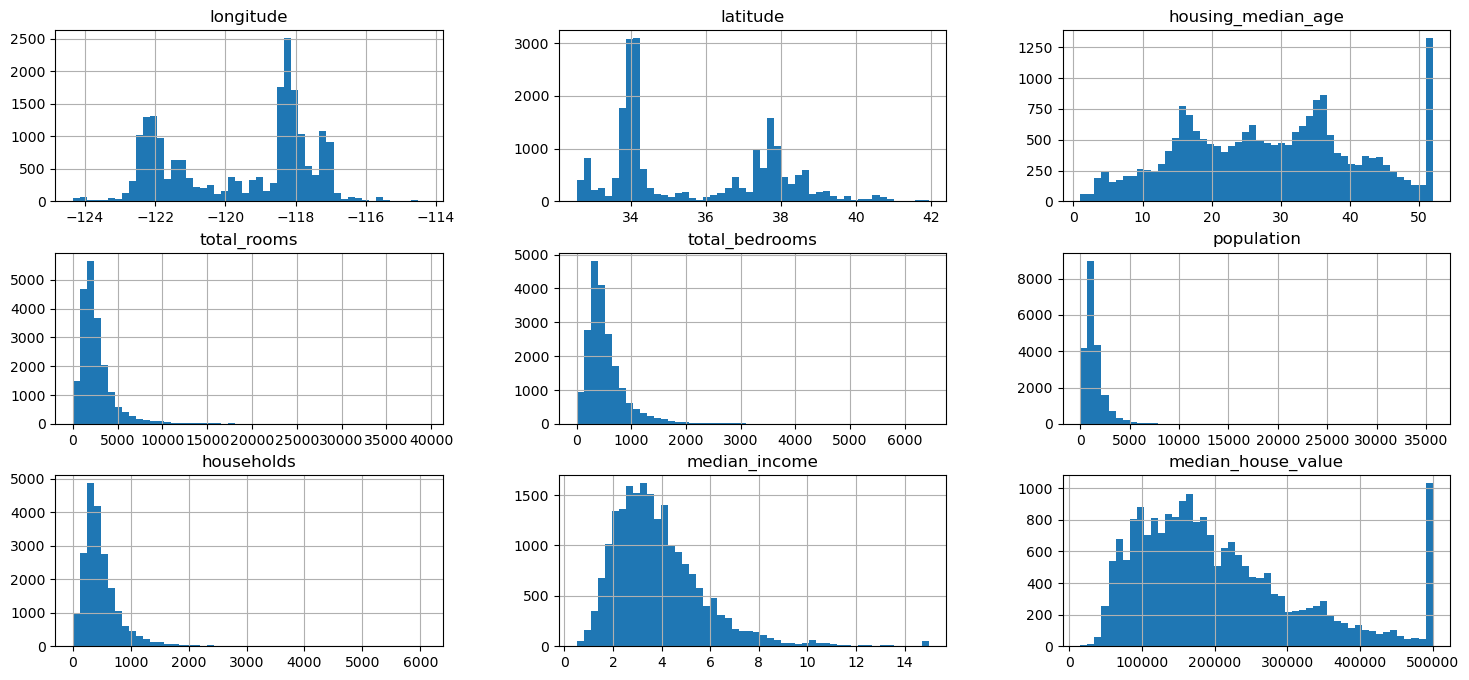

In [7]:
housing.hist(bins=50, figsize=(18,8))
plt.show()

In [8]:
def shuffle_and_split(data: DataFrame, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]

  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split(housing, 0.2)
print (len(train_set), len(test_set))

16512 4128


In [9]:
# Another way to do train/test split - take each instance's unique identifier, hash it and if the 
# hash value falls below 20% (or test ratio) of the max hash value, add it to the test set.

# Why does it work?
# Each hash is going to be a unique number in the range of 0-2^32. It's a function that maps a number to a hash.
# The domain of the function is changed to the range of the hash function. Therefore, if we said that all indices
# below 20 are test and the rest are train, if we take the hash of them and say all hashes that are below 
# 0.2 * 2**32 are test is an equivalent statement as long as the distribution of the hash values is uniform.

def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id: is_id_in_test_set(id, test_ratio))

  return data.loc[~in_test_set], data.loc[in_test_set]

# adds an index column
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

print (len(train_set), len(test_set))
print (len(test_set) / len(housing_with_id))

16512 4128
0.2


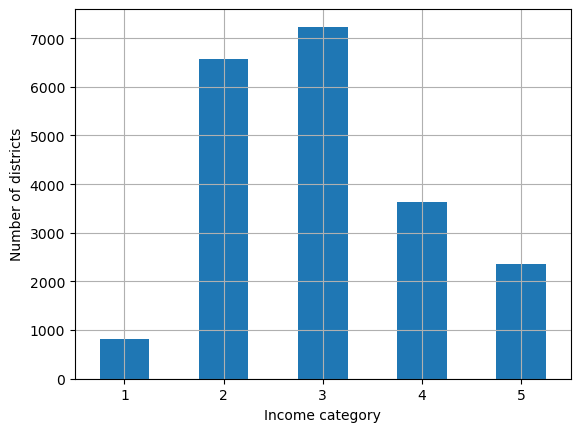

In [10]:
# Stratified split
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1,2,3,4,5])

# We can see that the data is not uniform, therefore, a non-stratified split will surely have a bias towards salaries in the
# ranges 1.5-3.0 and 3.0-4.5
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()


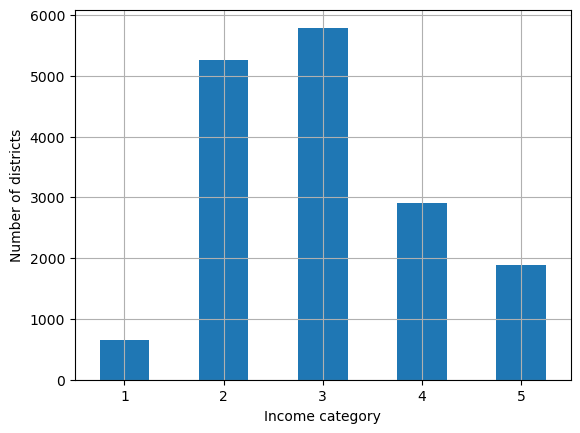

In [11]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

strat_train_set, strat_test_set = strat_splits[0]

strat_train_set["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [12]:
# removing the income_cat (was needed just for stratified split)
strat_train_set = strat_train_set.drop(["income_cat"], axis=1)
strat_test_set = strat_test_set.drop(["income_cat"], axis=1)

# make a copy of the training set for backup
housing = strat_train_set.copy()

# Visualizing the training set

Visualizing the training set and finding correlations between features

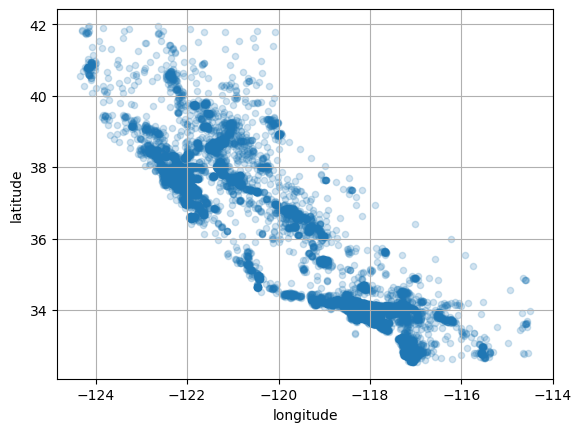

In [13]:
# Visualizing the training set

# Scatter plot of the lan/lat features 
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

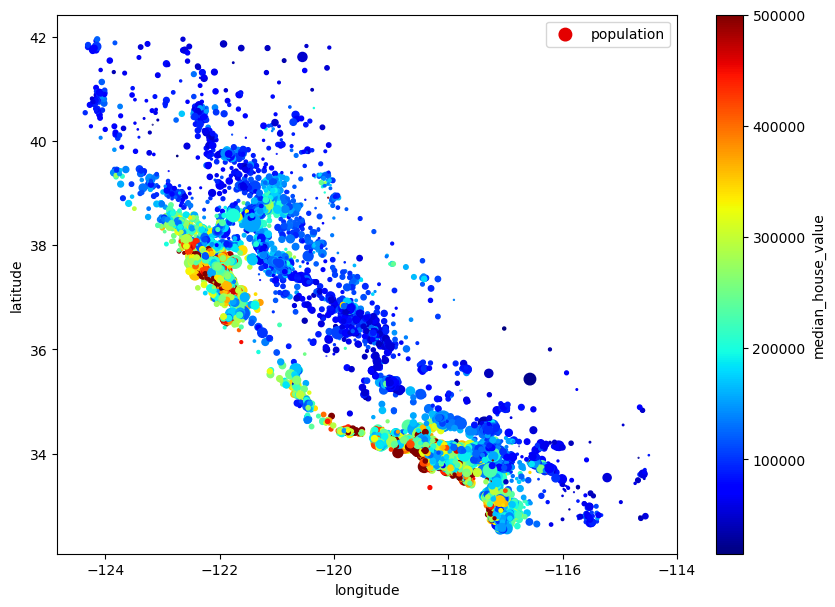

In [14]:
# Scatter plot of population size / price features over the lan / lat features.
# Population size is the circle's radius and the housing price is the color of the circle

housing.plot(kind="scatter", x="longitude", y="latitude",
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
plt.show()

In [15]:
# Using standard correlation coefficient (Pearson's r) between every pair of attributes.
# This results in a correlation coefficient between -1 to 1. This only finds linear correlations. Nonlinear correlations
# will get marked as zero by this coefficient.

# removing 'ocean_proximity' since the correlation works only with numerical columns
housing_no_categorical = housing.drop(["ocean_proximity"], axis=1)
corr_matrix = housing_no_categorical.corr()

# seeing the correlation between the target (house value) to other features
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

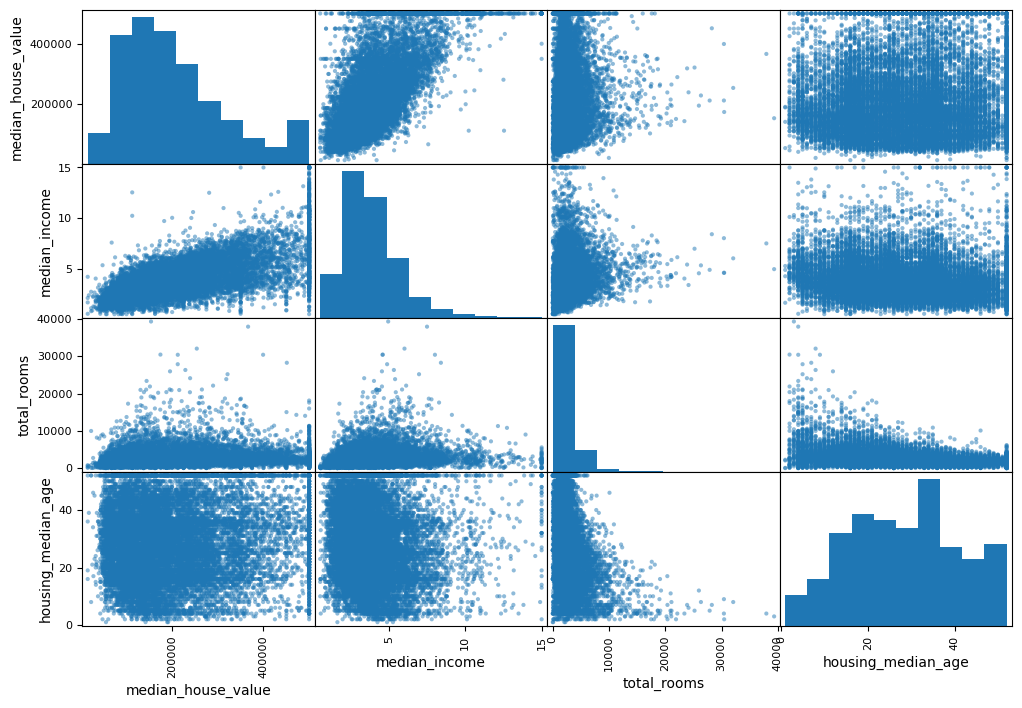

In [16]:
# Visualizing correlations of selected features

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

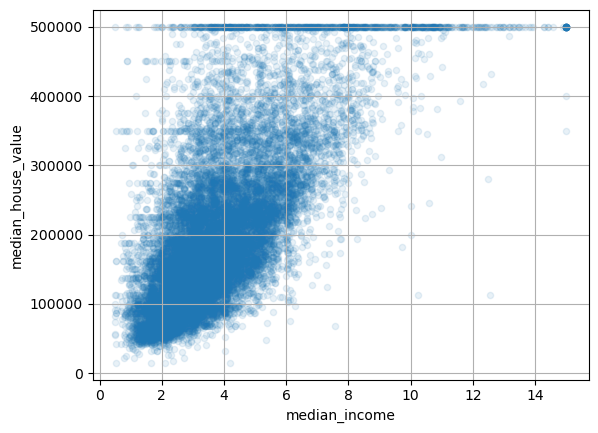

In [17]:
# Looking at the correlation matrix and the scatter matrix, the most correlated feature to house value is 
# the median_income

housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

# Experiment with feature combinations


In [18]:
# The features in the dataset are with respect to the district. For example, total_rooms means total number of rooms
# in a district. Similarly is the population and the total_bedrooms attributes. As we saw before, these numbers are not
# positively correlated much with the house value. 

# Instead, we can add features that will be per house (instead of per district)
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedroom_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

# And we can check the correlation of these new attributes to the house value
housing_no_categorical = housing.drop(["ocean_proximity"], axis=1)
corr_matrix = housing_no_categorical.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

# We can see a new negative linear correlation between the bedroom_ratio and the house value. The higher the bedroom_ratio
# is (more bedrooms than other rooms in a house), the lower the house value is.


median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedroom_ratio        -0.256397
Name: median_house_value, dtype: float64

# Prepare the data for a machine learning model

In [19]:
# Starting from a clean training dataset and separating the labels
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Handling missing values

In [20]:
# Imputing missing values by filling the column median. The imputer will remember the columns median so that we 
# can use it on validation/test sets to fill na and also for on-demand inference.
imputer = SimpleImputer(strategy="median")

# Create a copy of the data with only numerical values (ocean_proximity will get ignored in housing_num)
housing_num = housing.select_dtypes(include=[np.number])

# impute ALL missing numbers with column median. The reason why we want to compute median and impute for all columns, 
# even though only total_bedrooms had missing values, is because we dont know if new data points sent for inference will
# be missing values. If they do, we'll use the training set column median to fill them.
imputer.fit(housing_num)

# Replace the missing values in the training set
X = imputer.transform(housing_num)

# Wrap the imputer result (numpy array with no column names or row indexes) in a pandas dataframe 
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)


### Handling text and categorical attributes

In [21]:
# Handling text and categorical attributes

# Checking out the categorical column - ocean_proximity
housing_cat = housing[["ocean_proximity"]]
print (housing_cat.value_counts())

print (housing_cat[:8])

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64
      ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND
18078       <1H OCEAN
4396         NEAR BAY


In [22]:
# Handling text and categorical attributes

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

print (housing_cat_encoded[:8])

# A better approach would be to use one-hot encoder to remove any similarity from the encoded categories. 
# e.g after an ordinal encoding '<1H OCEAN' became 0 and 'INLAND' became 1 and so on. We don't want the
# model to think that <1H OCEAN is closer to INLAND more than NEAR_OCEAN which got 4.

# One hot encoder cancels out this numerical proximity from categorical encoding
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

# Similar to the imputer, we can use it downstream in the pipeline on the test data and new data points for inference.


[[3.]
 [0.]
 [1.]
 [1.]
 [4.]
 [1.]
 [0.]
 [3.]]


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### Feature scaling and transformation

In [23]:
# Scaling features

# Getting attributes to the same scale for better training performance. Data with different order of magnitudes in their
# features will be more biased to the larger features and won't learn as well from columns with smaller numbers.

# Option 1: min-max scaling
# (x - min) / (max - min)
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

# Option 2: standardization. Much less affected by outliers as it measures the distance from the mean in units of std
# (x - mean) / std
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

# Both these scaling techniques work well for normally distributed features. Heavy tail distributions that are scaled using
# these techniques will result in most values squashed into a very small range. This is not great for ML model training.
# Best to transform feature distributions into a normal one (using log transform for example) before applying these.

#### Transforming feature's distributions

Log - good for heavy tail distributions. Creates a normal distribution

Bucketizing - good for multimodal distributions (multi peak) moving the values into bins of roughly equal size. 
Creates a uniform distribution.

If you're transforming the target's distribution, the model will now try to predict the log of the target. Remember
to take the exponent of the prediction to get a number that makes sense.

(16512, 10)
[[0.1 0.  0.6 0.  0.  1.  0.  0.  0.  0.1]
 [0.  1.  0.  0.  0.  0.  0.1 0.  0.6 0. ]
 [0.4 0.  0.3 0.  0.  0.7 0.  0.  0.  0.3]]


/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


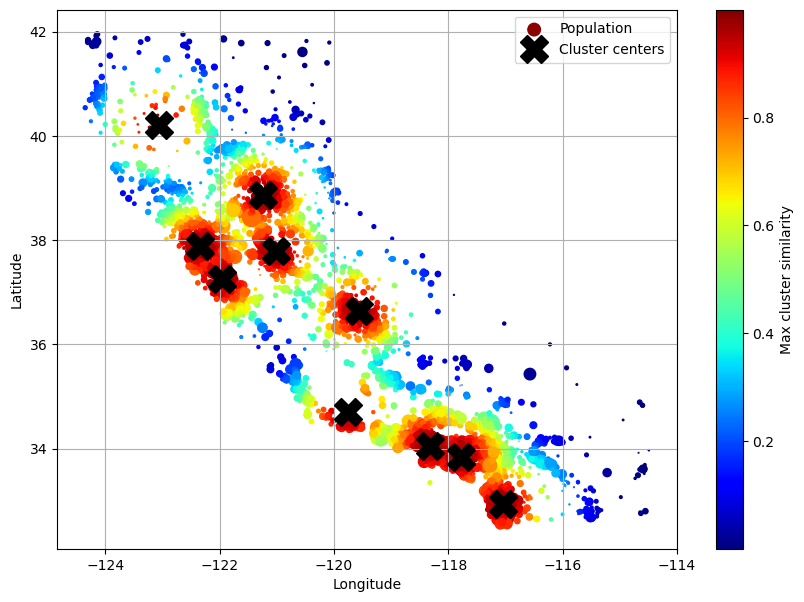

In [24]:
# Custom transformer example

# Doing KMeans to cluster the data and then using an RBF kernel using the cluster means as center points and passing in
# the dataset to see how close the data is to each center

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_cluster=10, gamma=1.0, random_state=None) -> None:
    super().__init__()

    self.n_cluster = n_cluster
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_cluster, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)

    return self
  
  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
  
  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_cluster)]
  

cluster_simil = ClusterSimilarity(n_cluster=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

# Result is a matrix with one row per district and 10 columns, one for each cluster center.
# It measures the similarity of each data point to each cluster center
print (similarities.shape)
print (similarities[:3].round(1))


# Add another to each row which is the similarity measure to its nearest cluster center
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

# scatter of population over long/lat with the similarity to nearest cluster as color gradient
housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))

# plt the cluster x,y coordinates
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")

# The plot shows that the closer a district is to a center, the higher the population is in that district
plt.legend(loc="upper right")
plt.show()


#### Transformation Pipelines

Wrapper objects that capture a pipeline of transformations to a dataset and executes them in order. Each pipeline can be seen as a sequence of 1 or more transformer and an optional predictor at the end of it. A pipeline has the same interface as a transformer - it has a `fit_transform` method. When its `fit_transform` is called, it calls each of its transformer's `fit_transform` and passes the output sequentially.

#### ColumnTransformer
This is a way to run preprocessing pipelines on columns and build a new dataset from the transformed features. The ColumnTransformer 
concatenates the output of each pipeline horizontally. It uses the name given to it as a prefix to the pipeline's `get_feature_names_out` method. 

In [25]:
# A pipeline is built using a sequence of scikit learn transformers and a final, optional predictor. When you call the pipeline's
# fit method, it'll call fit_transform for each transformer, passing the output of each one to the next. The final one (predictor)
# will only have its fit method called.

num_pipeline = Pipeline([
  ("impute", SimpleImputer(strategy="median")),
  ("standardize", StandardScaler())
])

cat_pipeline = Pipeline([
  ("most_frequent", SimpleImputer(strategy="most_frequent")),
  ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Column transformer will apply a transformer only to a subset of columns. This is helpful when you have transformations for 
# numerical columns (e.g scaling) and transformations for categorical columns (e.g one hot encoding).

# One option is to pass a list of column names so that the ColumnTransformer can choose the right ones to run the transformer on.
# The other option is to use  make_column_selector and specify the data type for each transformer (see below).
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

preprocessing = ColumnTransformer([
  ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
  ("cat", cat_pipeline, make_column_selector(dtype_include=object))
])

# Run preprocessing and wrap in a pandas data frame using column names and row index
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared = DataFrame(housing_prepared, 
                             columns=preprocessing.get_feature_names_out(),
                             index=housing.index)


#### Creating a single pipeline

Until now we experimented with different data transformations, imputation and encoding methods. Now we want to clean it up 
and create a single pipeline that captures all preprocessing steps. The steps are:

- Imputing missing numerical values with the median of column
- Imputing missing categorical values with the most frequent of the column
- Encode categorical features as one-hot
- Add new features that showed strong correlation to the label:
  * bedrooms_ratio
  * rooms_per_house
  * people_per_house
- Add cluster similarity features (see custom transformer above). These are measurements of how close a district is
  to a computed center (from KNN). Should be more useful than latitude/longitude
- Smooth feature distributions that are heavy-tailed with a log function
- Scale numerical feature using standardization

In [26]:
# Takes a numpy array and does a ratio of the first and second columns
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

# Returns a name. Used in the FunctionTransformer. The name will get appended to the ColumnTransformer
# column name
def ratio_name(function_transformer, feature_names_in):
  return ["ratio"]

# Pipeline to compute the ratio of any given two columns
def ratio_pipeline():
  return make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),
    StandardScaler()
  )

# Runs any given column in a log function for smoothing
log_pipeline = make_pipeline(
  SimpleImputer(strategy="median"),
  FunctionTransformer(np.log, feature_names_out="one-to-one"),
  StandardScaler()
)

# Computes centers and cluster similarity to these centers
cluster_simil = ClusterSimilarity(n_cluster=10, gamma=1, random_state=42)

# Impute and scale for any numerical features
default_num_pipeline = make_pipeline(
  SimpleImputer(strategy="median"),
  StandardScaler()
)

# Impute and encode for any categorical features
default_cat_pipeline = make_pipeline(
  SimpleImputer(strategy="most_frequent"),
  OneHotEncoder(handle_unknown="ignore")
)

# Building the pipeline from all parts above. Each 3-tuple is composed of (name, pipeline/transformer, columns to use for it).
preprocessing = ColumnTransformer([
  ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
  ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
  ("people_per_house", ratio_pipeline(), ["population", "households"]),
  ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
  ("geo", cluster_simil, ["latitude", "longitude"]),
  ("cat", default_cat_pipeline, make_column_selector(dtype_include=object)),
  ("num", default_num_pipeline, ["housing_median_age"]) 
])

# Running the preprocessing pipeline. Each pipeline/transformer will have its fit_transform method called with a numpy array
# composed of the columns provided. The transformed columns will get concatenated horizontally. Their names are provided
# by each pipeline's get_feature_names_out method
housing_prepared = preprocessing.fit_transform(housing)
print (housing_prepared.shape)
print (preprocessing.get_feature_names_out())

(16512, 24)
['bedrooms__ratio' 'rooms_per_house__ratio' 'people_per_house__ratio'
 'log__total_bedrooms' 'log__total_rooms' 'log__population'
 'log__households' 'log__median_income' 'geo__Cluster 0 similarity'
 'geo__Cluster 1 similarity' 'geo__Cluster 2 similarity'
 'geo__Cluster 3 similarity' 'geo__Cluster 4 similarity'
 'geo__Cluster 5 similarity' 'geo__Cluster 6 similarity'
 'geo__Cluster 7 similarity' 'geo__Cluster 8 similarity'
 'geo__Cluster 9 similarity' 'cat__ocean_proximity_<1H OCEAN'
 'cat__ocean_proximity_INLAND' 'cat__ocean_proximity_ISLAND'
 'cat__ocean_proximity_NEAR BAY' 'cat__ocean_proximity_NEAR OCEAN'
 'num__housing_median_age']


/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


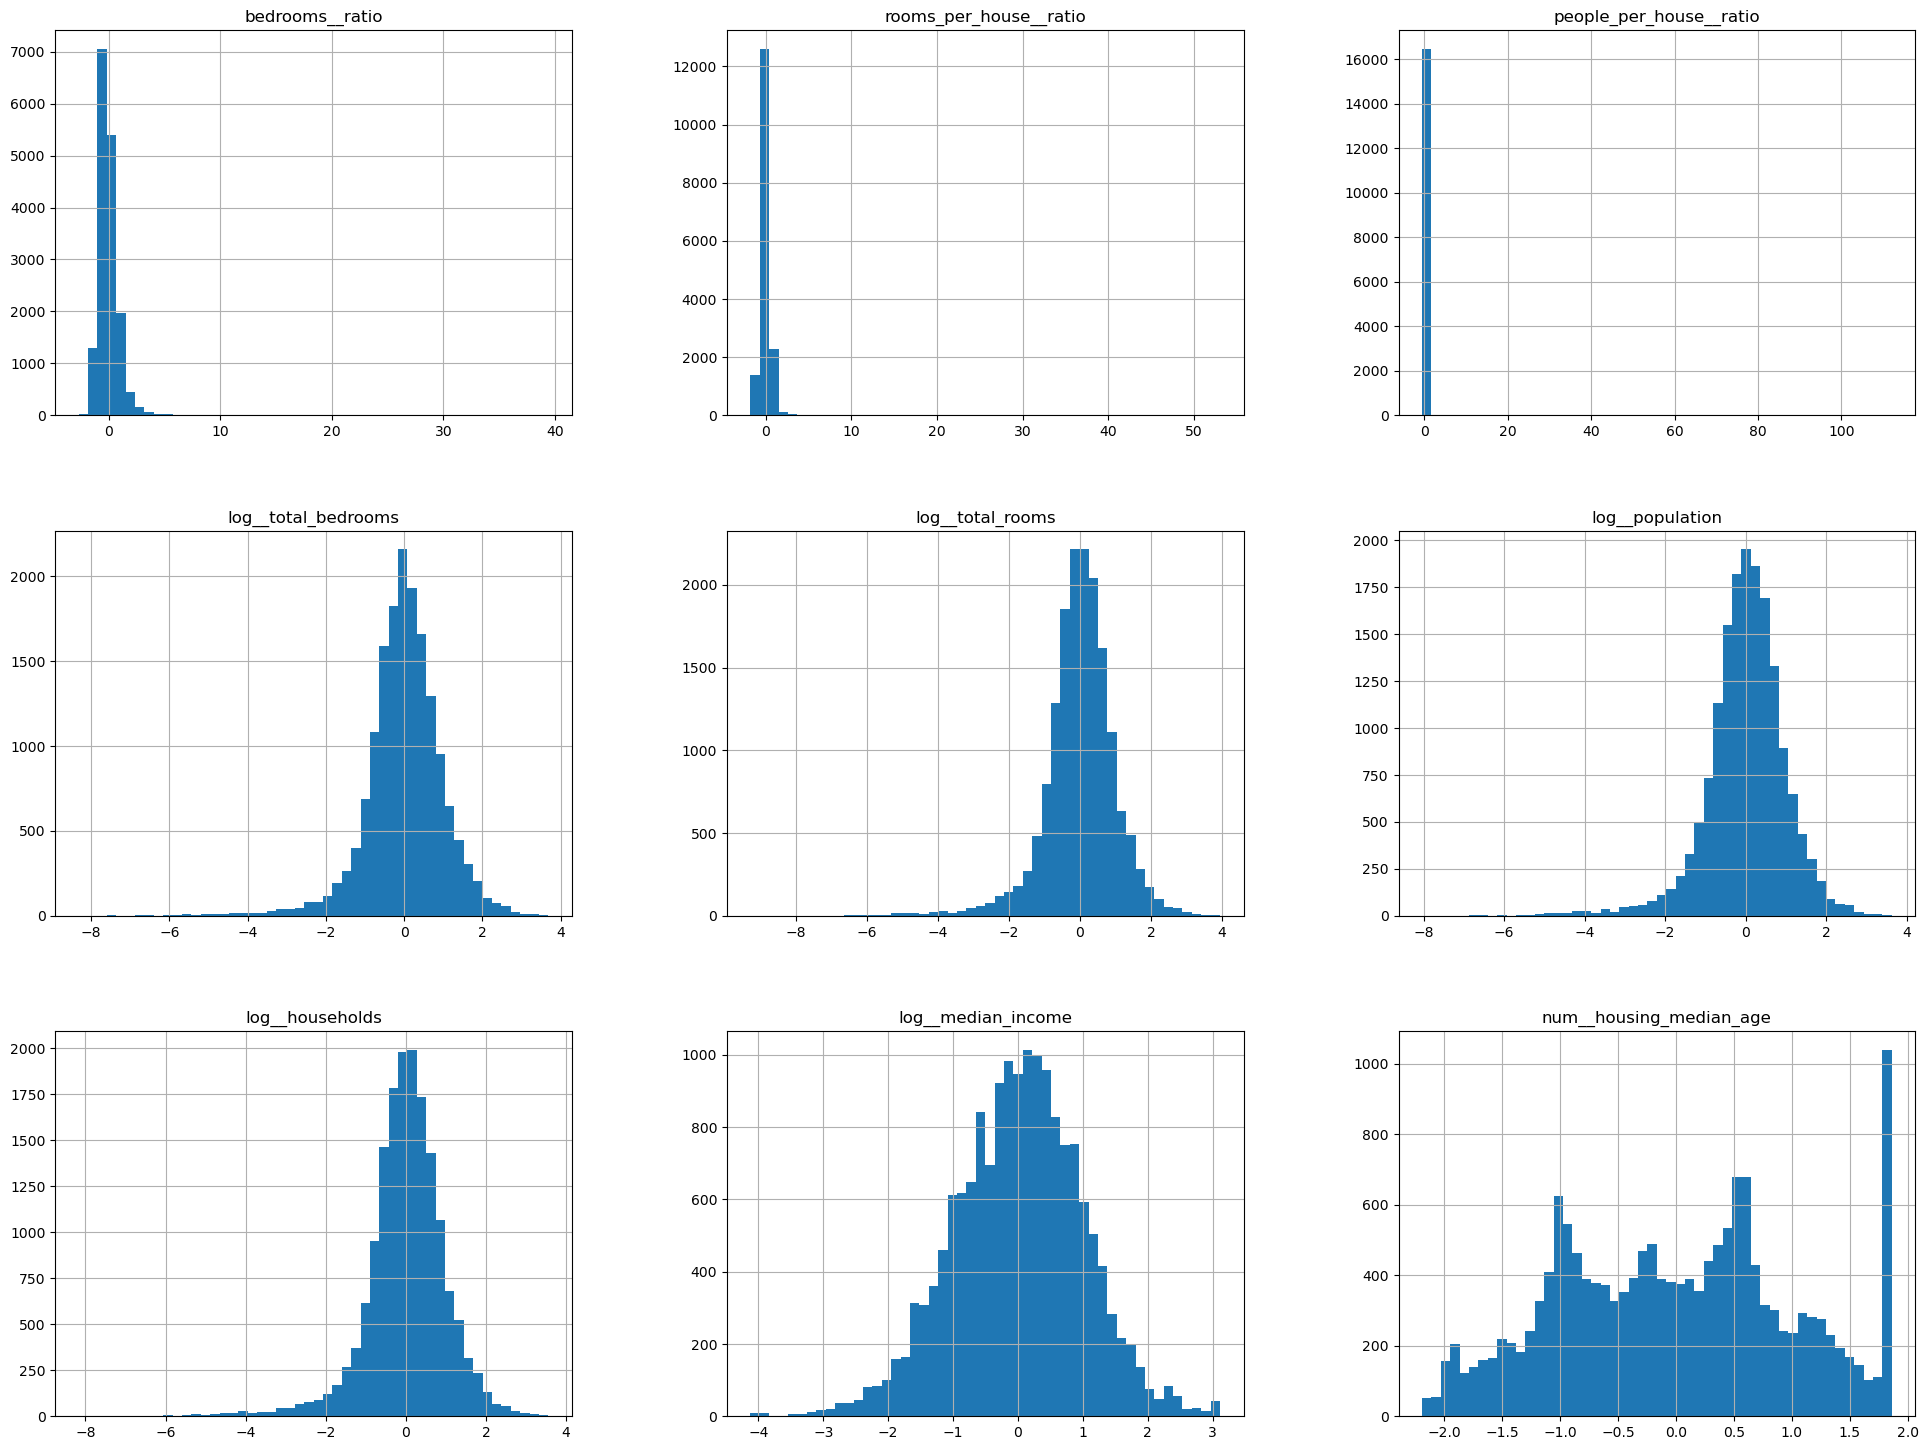

In [27]:
housing_prepared_df = DataFrame(housing_prepared, 
                                columns=preprocessing.get_feature_names_out(),
                                index=housing.index)

housing_prepared_df.drop(['geo__Cluster 0 similarity',
 'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
 'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
 'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
 'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
 'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
 'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
 'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN'], axis=1).hist(bins=50, figsize=(24,18))

plt.show()

# Training a Model

In [28]:
# Combining the preprocessing pipeline with a predictor
lin_reg = make_pipeline(
  preprocessing, 
  LinearRegression()  
)

lin_reg.fit(housing, housing_labels)

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x29cc2c720>,
                                                                                       func=<function column_ratio at 0x29cc2c680>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_r...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x29c8611d0>),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['housing_median_age'])])),
                ('linearregression', LinearRegression())])

In [29]:
housing_predictions = lin_reg.predict(housing)
print ("Predicted: ", housing_predictions[:5].round(-2))
print ("Actual: ", housing_labels[:5].values)

Predicted:  [242800. 375900. 127500.  99400. 324600.]
Actual:  [458300. 483800. 101700.  96100. 361800.]


In [30]:
# Evaluate linear regression model on the training dataset

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print ("Lin reg RMSE: ", lin_rmse)

# An RMSE of 68647 in the case of house values means that on average the error in prediction a house value is around $68,647.
# This model is underfitting - performing poorly on the training data


Lin reg RMSE:  68647.95686706656


In [31]:
# Trying with a different model - Decision Tree Regressor

tree_reg = make_pipeline(
  preprocessing,
  DecisionTreeRegressor(random_state=42)
)

tree_reg.fit(housing, housing_labels)

housing_predictions = tree_reg.predict(housing)
print ("Predicted: ", housing_predictions[:5].round(-2))
print ("Actual: ", housing_labels[:5].values)

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Predicted:  [458300. 483800. 101700.  96100. 361800.]
Actual:  [458300. 483800. 101700.  96100. 361800.]


In [32]:
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print ("RMSE: ", tree_rmse)

# This model has the opposite problem to the linear regression model - it most likely overfits the data

RMSE:  0.0


#### Evaluation using cross-validation

One way to evaluate a model is to create a train/validation/test sets and then evaluate the model on the validation set. 

Another way is to use k-fold cross validation: 
* It randomly splits the training set into k subsets. 
* Then it trains the model on k-1 of these subsets and validates on the remaining subset. 
* It repeats this process k times, resulting in k validation scores.

In [33]:
# The cross val score expects a utility function rather than a cost function. This means a function where greater score is
# considered better. We use the negative RMSE - higher scores mean lower error. To get the RMSE we just need to flip the sign

tree_rmses = -1 * cross_val_score(tree_reg, housing, housing_labels, 
                             scoring="neg_root_mean_squared_error", cv=10)

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/skle

In [34]:
# Now we can see that the tree regressor isn't doing as well as we thought. It overfitted on the training data and when
# it was presented with new data (validation set k-1 in each cv iteration), it got an RMSE closer to that we saw with
# the linear regression model.

# Since the k-fold cv score contains k RMSE scores (it trains and validates the model k times), we can get more statistics
# over the validation scores. For example, an std of 1963 tells us the average distance from the mean of all k scores, which can
# help see if there were outliers in the validation scores

pd.Series(tree_rmses).describe()

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

In [35]:
# Trying another model that's known to reduce overfitting - Random Forest Regressor

forest_reg = make_pipeline(
  preprocessing,
  RandomForestRegressor(random_state=42)
)

forest_rmses = -1 * cross_val_score(forest_reg, housing, housing_labels,
                                    scoring="neg_root_mean_squared_error", cv=10)

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/skle

In [36]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

In [37]:
# Looks like the random forest model does much better on the validation set (RMSE - 47000). Let's compare it to the
# RMSE of the training set (17500). It's still much lower than the validation error which points at overfitting.

tree_reg = make_pipeline(
  preprocessing,
  RandomForestRegressor(random_state=42)
)

tree_reg.fit(housing, housing_labels)
housing_predictions = tree_reg.predict(housing)

print ("random forest RMSE (train): ", mean_squared_error(housing_labels, housing_predictions, squared=False))

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


random forest RMSE (train):  17547.52124624957


# Fine-Tune Your Model

#### Grid Search

In [38]:
full_pipeline = Pipeline([
  ("preprocessing", preprocessing),
  ("random_forest", RandomForestRegressor(random_state=42))
])

# Since we're using composite pipelines to process the training data, our hyperparameters are buried deep in the 
# pipeline's transformers and predictors. To access these parameters we use the pipeline's name followed by underscore
# to get to the pipeline/transformer/predictor name followed by the name of the hyperparameter we're changing.

# For example, preprocessing__geo__n_cluster -> 
# preprocessing pipeline, geo transformer (ClusterSimilarity), n_cluster hyperparameter 
param_grid = [
  {'preprocessing__geo__n_cluster': [5,8,10],
   'random_forest__max_features': [4,6,8]},
   {'preprocessing__geo__n_cluster': [10,15],
    'random_forest__max_features': [6,8,10]}
]

# First set of hyperparameters options will yield 3 * 3 = 9 combinations, the second set will yield 2 * 3 = 6 combinations.
# 9 + 6 = 15 different parameter combinations to try over 3 CV rounds (k = 3) yields 15 * 3 = 45 training/evaluation rounds.
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/skle

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_name at 0x29cc2c720>,
                                                                                                              func=<function column_ratio at 0x29cc2c680>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['...
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['housing_median_age'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_cluster': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_cluster': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [39]:
# Getting the best parameters from the grid search
print (grid_search.best_params_)

# Getting the evaluation data from the grid search
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="rank_test_score", ascending=True, inplace=True)
cv_res.head()

# We can see that the mean RMSE for the best set of parameters is ~44000. We managed to improve (previous one was 47000).

# To get the best model instance
final_model = grid_search.best_estimator_

{'preprocessing__geo__n_cluster': 15, 'random_forest__max_features': 6}


#### Randomized Search

In [40]:
# Preferable when number of hyperparameter combination is large. 

params_ditribs = {'preprocessing__geo__n_cluster': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=params_ditribs, n_iter=10, cv=3,
                                scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/skle

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x29cc2c720>,
                                                                                                                    func=<function column_ratio at 0x29cc2c680>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler()...
                                                                               ['housing_median_age'])])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_cluster': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x29d021fd0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x29d082390>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [41]:
# Getting the best model and its hyperparameters. We can see further improvement (41000) 
final_model = rnd_search.best_estimator_
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="rank_test_score", ascending=True, inplace=True)
cv_res.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_cluster,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,5.298079,0.043711,0.112382,0.005530,45,9,"{'preprocessing__geo__n_cluster': 45, 'random_...",-41098.562794,-42150.259582,-42701.415315,-41983.412563,664.912273,1
8,4.183466,0.039100,0.109589,0.003611,32,7,"{'preprocessing__geo__n_cluster': 32, 'random_...",-41603.593716,-42199.816021,-43219.472170,-42340.960636,667.186704,2
5,2.680042,0.028386,0.110324,0.001847,42,4,"{'preprocessing__geo__n_cluster': 42, 'random_...",-41798.210275,-42966.898886,-43536.021702,-42767.043621,723.396496,3
0,8.793712,0.076893,0.107900,0.004821,41,16,"{'preprocessing__geo__n_cluster': 41, 'random_...",-42105.685594,-42742.754514,-43458.697825,-42769.045978,552.677697,4
2,4.793110,0.240827,0.084824,0.000450,23,8,"{'preprocessing__geo__n_cluster': 23, 'random_...",-42421.831357,-43108.478811,-43831.800223,-43120.703464,575.682281,5


#### Feature Importance

Some models (such as the RandomForest one), can output how each feature contributed to the learning. This can help us better deal with improving model performance since the non-important features can be dropped to reduce overfitting.

In [42]:
feature_importance = final_model["random_forest"].feature_importances_
feature_importance_w_labels = sorted(zip(feature_importance, final_model["preprocessing"].get_feature_names_out()), reverse=True)
pprint.pprint (feature_importance_w_labels)


[(0.19087378222226137, 'log__median_income'),
 (0.07625632853052883, 'cat__ocean_proximity_INLAND'),
 (0.06365028932207333, 'bedrooms__ratio'),
 (0.057834740538722625, 'rooms_per_house__ratio'),
 (0.04907003277818634, 'people_per_house__ratio'),
 (0.038165489600129165, 'geo__Cluster 3 similarity'),
 (0.025700861301416925, 'geo__Cluster 22 similarity'),
 (0.02186407550147744, 'geo__Cluster 17 similarity'),
 (0.021818299311019237, 'geo__Cluster 6 similarity'),
 (0.018249904787654904, 'geo__Cluster 2 similarity'),
 (0.017263517651784216, 'geo__Cluster 32 similarity'),
 (0.015649725317935348, 'geo__Cluster 18 similarity'),
 (0.015236556682888558, 'geo__Cluster 40 similarity'),
 (0.014160249342841777, 'geo__Cluster 43 similarity'),
 (0.014113856232349186, 'geo__Cluster 7 similarity'),
 (0.013968406769681294, 'geo__Cluster 21 similarity'),
 (0.013781633271007265, 'geo__Cluster 38 similarity'),
 (0.013515022744382842, 'geo__Cluster 34 similarity'),
 (0.013508738042902313, 'geo__Cluster 41 sim

#### Evaluate your final model on the test set

In [43]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print ("Final RMSE: ", final_rmse)

Final RMSE:  41536.20954091729


In [46]:
# We can compute a confidence interval that'll tell us the range where 95% of the errors are. In other words, instead of getting
# an average RMSE, we can ask what's the RMSE range for 95% of the samples we predicted 

confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([39391.51194455, 43575.47696556])

# Launch, Monitor and Maintain Your System

In [48]:
# This model relies on a few custom functions and transformers to preprocess the data (ClusterSimilarity, column_ratio, etc.). It
# also relies on many built in ones (KMeans, rbf_kernel, etc...). When we reload it in a different program, we need to make
# sure that all that code is there (it's not getting pickled with the model).

joblib.dump(final_model, "california_housing_model.pkl")

['california_housing_model.pkl']

In [58]:
np.array(X_test.iloc[0])


array([-121.95, 37.11, 21.0, 2387.0, 357.0, 913.0, 341.0, 7.736,
       '<1H OCEAN'], dtype=object)